# Electricity fraud detection based on hybrid attention model

The notebook is based on original paper "Electricity Theft Detection with self-attention" by Paulo Finardi, Israel Campiotti, Gustavo Plensack, Rafael Derradi de Souza, Rodrigo Nogueira, Gustavo Pinheiro, Roberto Lotufo (https://arxiv.org/abs/2002.06219). 
Source code is derived from their repository https://github.com/neuralmind-ai/electricity-theft-detection-with-self-attention.
The purpose of the notebook is refactoring and further investigation of the original paper.

The notebook organazed as follows. First step is an initialization. It is performed to load all high-level modules that incapsulates low-level code. Second step is a data investigation. Next - training. Final step is a performance metrics calculation.

### 1. Initialization

The notebook contains a data investigation, basic training and performance calculation steps. They are based on high-level modeules that are loaded in this section. For Colab environment source code is cloned at first step (it may be uncommented if it is required). 

In [7]:
# Uncomment code below to run in a Colab environment
! git clone https://github.com/ant-nik/electricity-theft-detection-with-self-attention.git
% cd electricity-theft-detection-with-self-attention

Cloning into 'electricity-theft-detection-with-self-attention'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 50 (delta 17), reused 38 (delta 8), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/electricity-theft-detection-with-self-attention/electricity-theft-detection-with-self-attention


Below you an find high-level description of imported modules.
- FraudData object simplifies access to various views of a raw data (raw/normalized, thief/regular, autocorelations etc);
- HybridAttentionModel - defines hybrid attention model based on torch library; 
- perform_kfold_cv - a training routine;
- RAdam - training optimizer implementation;

In [1]:
from source.dataset import FraudData, download_data
from source.hybrid_attention import HybridAttentionModel
from source.train import perform_kfold_cv
from source.optimizer import RAdam
from torch import nn
from matplotlib import pyplot

Final step of initialization is a raw data downloading process is required. It can be done manually or by a routine (it may be issue in Windows if there is no unix utils in OS, so manual loading is more stable).

In [2]:
# It may be issues in Windows environments, so manual downloading may be required.
# Uncomment in a Colab environment
#download_data() 
data = FraudData('data.csv')

### 1. Dataset investigation

A dataset has a lot of missed values and the authors of the original paper suggested to replace them with zeros and add an additional channel with bitmask to signal a classifier about missed value. It is a good choice in a classifier's learning process but according to time series properties such kind of transformation might introduce a distortion to results.

Below the raw data is processed in a different way in order to calculate autocorrelation characteristic. It is split in chunks without missed values and only chanks with enough size are processed to calculate autocorrelation (limit size is approximately two times greter than maximum of an autocorrelation lag). Autocorrelation results are obtained for four groups of data: thiefs and regular clients data, thiefs and regular clients normalized data. A normalization is performed to stabilize parameters of the raw data.

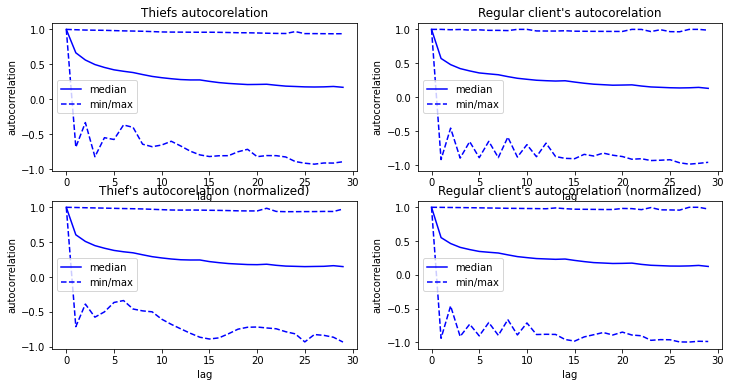

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2,2, figsize=(12,6))
vis = [
    {'title': "Thiefs autocorelation", 
         'ax': ax1, 'data': data.thief_ac},
    {'title': "Regular client's autocorelation", 
         'ax': ax2, 'data': data.regular_ac},
    {'title': "Thief's autocorelation (normalized)", 
         'ax': ax3, 'data': data.norm_thief_ac},
    {'title': "Regular client's autocorelation (normalized)", 
         'ax': ax4, 'data': data.norm_regular_ac}
]
for view in vis:
    view['ax'].set_title(view['title'])
    view['data'].mean(axis=1).plot(ax=view['ax'], legend=True, style='b-')
    view['data'].max(axis=1).plot(ax=view['ax'], legend=True, style='b--')
    view['data'].min(axis=1).plot(ax=view['ax'], legend=True, style='b--')
    view['ax'].legend(['median', 'min/max'])
    view['ax'].set_xlabel('lag')
    view['ax'].set_ylabel('autocorrelation')

### 2. Attention model learning

The authors of the original paper suggested to use a hybrid classifier that is complex neural network with convolutional and attention layers that forms a basic blocks. A learn process is performed as fold-learning with Adam optimizer and cross entropy loss function.

In [ ]:
k_folds = 2
lr = 0.001
device = 'cpu'
models = [HybridAttentionModel().to(device) for _ in range(k_folds)]
optims = [RAdam(model.parameters(), lr) for model in models]
criterion = nn.CrossEntropyLoss()
f1_per_fold = perform_kfold_cv(data.normalized, models, optims, criterion, 
                               k_folds, device=device, n_epochs=1)

--- K Fold [1/2] ---


### 3. Attention model performance

Result of learning are represented as a set of learned model files. They can be loaded to classify new inputs. The learning process outputs metric values that is used below to find a model with best score.

In [13]:
best_fold = f1_per_fold.index(sorted(f1_per_fold, key=lambda x:x[0], reverse=True)[0]) + 1
best_f1, best_epoch,_,_ = f1_per_fold[best_fold-1]
print(f'The best fold ,was {best_fold} with F1 of {best_f1} at epoch {best_epoch}')

The best fold ,was 2 with F1 of 0.6062780269058297 at epoch 16
